###Импорты, статистические функции, палетки

In [ ]:
pip install opendatasets

In [ ]:
pip install scikit_posthocs

In [ ]:
import numpy as np
import pandas as pd
import opendatasets as od
import statsmodels as sm
import statsmodels.api as stm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from scipy.stats import ks_2samp
from scipy.stats import kruskal
import scikit_posthocs as sp
from typing import Iterable, Literal, List, Union, Tuple, Optional
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from statsmodels.stats.diagnostic import het_white

In [ ]:
od.download('https://www.kaggle.com/datasets/egorkainov/moscow-housing-price-dataset')

Skipping, found downloaded files in "./moscow-housing-price-dataset" (use force=True to force download)


In [ ]:
df = pd.read_csv('/content/moscow-housing-price-dataset/data.csv')

In [ ]:
#кастомные палетки для визуализации
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
dark_pastel_palette = ['#FF69B4', '#1E90FF', '#32CD32']
light_pastel_colors =['lightblue', 'lightpink', 'lightgreen','lightcoral','lightgray']

In [ ]:
def add_statistics_to_table(stats_df, column, column_name):
    """Добавляет статистики для указанного столбца в таблицу stats_df"""

    stats = {
        'Среднее': column.mean(),
        'Дисперсия': column.var(),
        'Мода': column.mode().values[0],
        'Медиана': column.median(),
        '1-й квартиль': column.quantile(0.25),
        '2-й квартиль': column.quantile(0.50),
        '3-й квартиль': column.quantile(0.75),
        '4-й квартиль': column.quantile(1.0)
    }


    stats_df[column_name] = pd.Series(stats)
    return stats_df

In [ ]:
def normal_or_not(group: Iterable, test: Literal['Shapiro', 'KS']):
    '''Проверяет нормальность распределения по тестам Шапиро-Уилка и Колмогорова-Смирнова'''

    if test == "Shapiro":
        W_statistic, w_p_val = sts.shapiro(group)
        test_name = "Шапиро-Уилка"
    elif test == "KS":
        # Для KS теста используем среднее и стандартное отклонение данных
        mean, std = np.mean(group), np.std(group)
        W_statistic, w_p_val = sts.kstest(group, 'norm', args=(mean, std))
        test_name = "Колмогорова-Смирнова"
    else:
        raise ValueError("Неверный тест. Используйте 'Shapiro' или 'KS'.")

    print('W_statistic:', round(W_statistic, 3), "\n", 'w_p_val:', round(w_p_val, 3))
    if round(w_p_val, 3) >= 0.05:
        print(f"Выборочное распределение подчиняется нормальному закону по тесту {test_name}.")
    else:
        print(f"Выборочное распределение не подчиняется нормальному закону по тесту {test_name}.")

In [ ]:

def spearman(a : Iterable, b: Iterable):
    '''расчёт корреляции Спирмана'''

    r_s_stats, p_value_stats = spearmanr(a, b)
    print("Коэффициент корреляции Спирмана:", round(r_s_stats, 4))
    print("p-value:", round(p_value_stats, 4))


def pearson(a : Iterable, b: Iterable):
    '''расчёт корреляции Пирсона'''

    r_s_stats, p_value_stats = pearsonr(a, b)
    print("Коэффициент корреляции Пирсона:", round(r_s_stats, 4))
    print("p-value:", round(p_value_stats, 4))

In [ ]:
def efr_mean_diff(group1 : Iterable, group2 : Iterable, n_iterations = 100, alpha = 0.05):
    '''рассчитывает эфронов доверительный интервал на основе бутстрепа'''
    diffs = []
    n1 = len(group1)
    n2 = len(group2)
    for _ in range(n_iterations):
        # бутстреп для двух сегментов
        sample1 = np.random.choice(group1, size=n1, replace=True)
        sample2 = np.random.choice(group2, size=n2, replace=True)
        # Вычисляем разницу медиан
        diff = np.median(sample1) - np.median(sample2)
        diffs.append(diff)
    lower = np.percentile(diffs, 100*alpha/2)
    upper = np.percentile(diffs, 100*(1-alpha/2))

    print(f"95% эфронов интервал для разности медиан: ({round(lower, 3)}, {round(upper, 3)})")

In [ ]:
def calculate_vif(df: pd.DataFrame, columns: List[str]):
  '''Рассчитывает VIF'''

  #выберем колонки
  X = df[columns]

  # добавляем intercept
  X = stm.add_constant(X)

  # расчет VIF для каждой переменной
  vif_data = pd.DataFrame()
  vif_data["Variable"] = X.columns
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  return vif_data

#**Обзор датасета и постановка задачи**

Попробуем проанализировать цены квартир в Москве по набору данных c Kaggle. В наборе 1 целевая непрерывная переменная - Price и 11 регрессоров:

- 'Apartment type' - категориальный признак
- 'Metro station' - категориальный
- 'Minutes to metro' - количественный непрерывный признак
- 'Region' - категориальный
- 'Number of rooms' - количественный дискретный признак
- 'Area' - количественный непрерывный признак
- 'Living area' - количественный непрерывный признак
- 'Kitchen area' - количественный непрерывный признак
- 'Floor' - количественный дискретный признак
- 'Number of floors' - количественный дискретный признак
- 'Renovation' - категориальный


In [ ]:
df.columns

Index(['Price', 'Apartment type', 'Metro station', 'Minutes to metro',
       'Region', 'Number of rooms', 'Area', 'Living area', 'Kitchen area',
       'Floor', 'Number of floors', 'Renovation'],
      dtype='object')

In [ ]:
df.head()

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.00,Secondary,Опалиха,6.00,Moscow region,1.00,30.60,11.10,8.50,25.00,25,Cosmetic
1,9000000.00,Secondary,Павшино,2.00,Moscow region,1.00,49.20,20.00,10.00,6.00,15,European-style renovation
2,11090000.00,Secondary,Мякинино,14.00,Moscow region,1.00,44.70,16.20,13.10,10.00,25,Cosmetic
3,8300000.00,Secondary,Строгино,8.00,Moscow region,1.00,35.10,16.00,11.00,12.00,33,European-style renovation
4,6450000.00,Secondary,Опалиха,6.00,Moscow region,1.00,37.70,15.20,4.00,5.00,5,Without renovation


In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,Price,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors
count,22676.00,22676.00,22676.00,22676.00,22676.00,22676.00,22676.00,22676.00
mean,36121321.82,11.89,2.04,71.97,38.52,12.59,9.19,16.56
std,82825614.18,6.20,1.52,68.37,38.12,7.73,7.55,9.78
min,1150000.00,0.00,0.00,6.00,2.00,1.00,1.00,1.00
25%,7068116.00,7.00,1.00,37.40,17.60,8.60,4.00,11.00
50%,11343200.00,11.00,2.00,53.30,28.50,10.60,8.00,16.00
75%,24799247.50,15.00,3.00,77.14,43.20,14.50,13.00,20.00
max,2455020000.00,60.00,12.00,1117.00,566.80,122.00,92.00,97.00


In [ ]:
df.shape

(22676, 12)

In [ ]:
df.isna().sum()

,0
Price,0
Apartment type,0
Metro station,0
Minutes to metro,0
Region,0
Number of rooms,0
Area,0
Living area,0
Kitchen area,0
Floor,0


Пропущенные значения отсутствуют

#**EDA**

##**Целевая переменная**

Определим:
- Распределение целевой переменной
- Наличие выбросов
- Описательные статистики

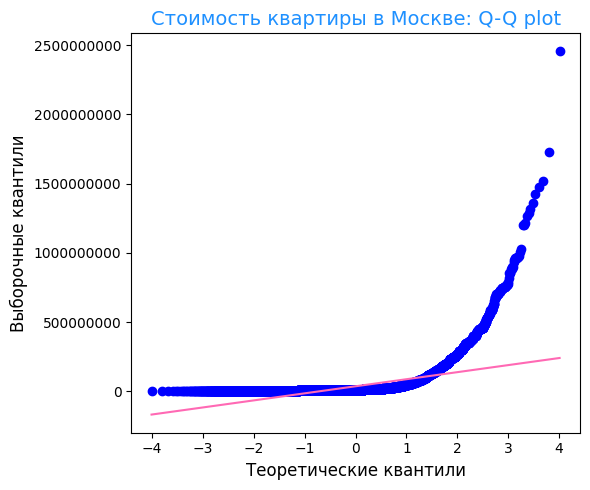

In [ ]:
plt.figure(figsize=(6, 5))
sts.probplot(df.Price, dist="norm", plot=plt)

#покрасим кастомно
line = plt.gca().get_lines()[1]
line.set_markerfacecolor(dark_pastel_palette[1])
line.set_markeredgecolor(dark_pastel_palette[1])
line.set_color(dark_pastel_palette[0])


plt.title('Стоимость квартиры в Москве: Q-Q plot', color=dark_pastel_palette[1], fontsize=14)
plt.xlabel('Теоретические квантили', fontsize=12)
plt.ylabel('Выборочные квантили', fontsize=12)


plt.ticklabel_format(style='plain', axis='both')

plt.tight_layout()
plt.show()

Сразу сталкиваемся с особенностями в данных: распределение далеко от нормального, сильный разброс в цене, выбросы (максимальная цена на порядки отличается даже от значений в 3 квартиле). Для таких данных сложно подобрать визуализацию, выбросы на графике будут создавать экстремальные значения.
Так как планируется построение линейной регрессии, стоит сразу подумать о выполнении предпосылок Гаусса-Маркова и трактуемости результата. Линейная регрессия допускает нелинейные преобразования над исходными данными, хотя это и может привести к следующим рискам:
- корреляция ошибки с регрессорами
- нарушение логики поведения целевой переменной
- проблема пропущенных переменных.
Запомним риски и сделаем log-level преобразование, но сохраним скорректированный таргет в отдельной колонке, чтобы была возможность производить другие преобразования и сравнения. Для этой колонки построим визуализацию, которая будет более интерпретируема.

In [ ]:
df['Log_Price'] = np.log10(df.Price)

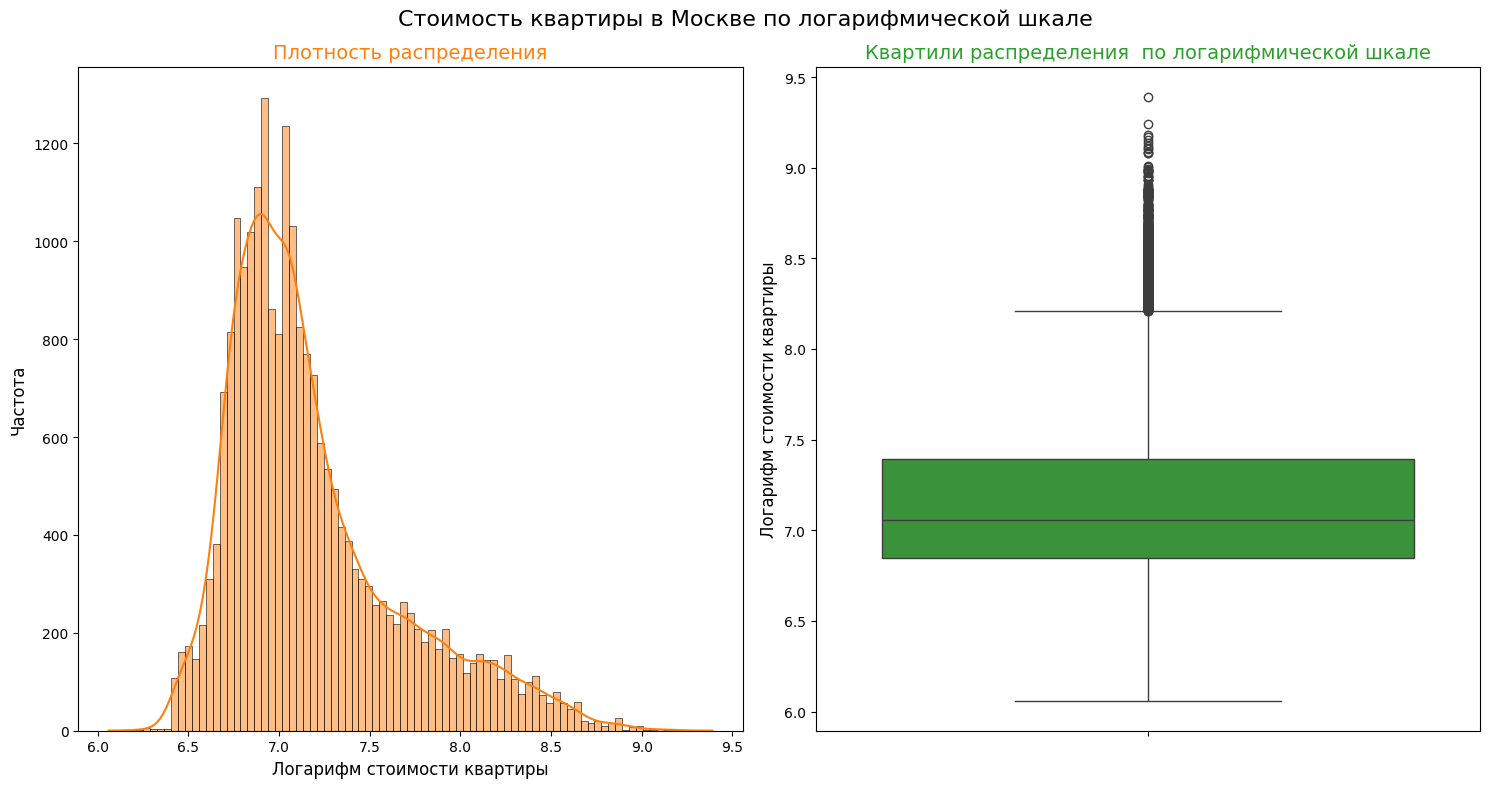

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.suptitle('Стоимость квартиры в Москве по логарифмической шкале', fontsize=16)

# гистограмма
sns.histplot(df.Log_Price, kde=True, ax=axes[0], color=custom_palette[1])
axes[0].set_title('Плотность распределения', color=custom_palette[1], fontsize=14)
axes[0].set_xlabel('Логарифм стоимости квартиры', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)

plt.ticklabel_format(style='plain', axis='both')

# боксплот
sns.boxplot(y=df.Log_Price, ax=axes[1], color=custom_palette[2], orient='v')
axes[1].set_title('Квартили распределения  по логарифмической шкале', color=custom_palette[2], fontsize=14)
axes[1].set_ylabel('Логарифм стоимости квартиры', fontsize=12)

plt.tight_layout()
plt.show()

Для логарифмированного таргета всё еще получаем распределение с тяжелым правым хвостом, и на боксплоте многочисленные выбросы. Для бизнес-целей было бы логично выделить сегменты квартир - например, эконом, люкс, премиум, и составить зависимости и отчеты для каждого сегмента. Однако в текущем наборе данных разделение отсутствует, попробуем выявить закономерности в ходе исследования.
Создадим данные о квартилях распределения цены.

In [ ]:
df['Quartile'] = pd.qcut(df.Price, q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

Сохраним описательные статистики для целевой переменной

In [ ]:
stats = {
    'Стоимость': {
        'Среднее': df['Price'].mean(),
        'Дисперсия': df['Price'].var(),
        'Мода': df['Price'].mode().values[0],
        'Медиана': df['Price'].median(),
        '1-й квартиль': df['Price'].quantile(0.25),
        '2-й квартиль': df['Price'].quantile(0.50),
        '3-й квартиль': df['Price'].quantile(0.75),
        '4-й квартиль': df['Price'].quantile(1.0)
    },
    'Логарифм стоимости': {
        'Среднее': df['Log_Price'].mean(),
        'Дисперсия': df['Log_Price'].var(),
        'Мода': df['Log_Price'].mode().values[0],
        'Медиана': df['Log_Price'].median(),
        '1-й квартиль': df['Log_Price'].quantile(0.25),
        '2-й квартиль': df['Log_Price'].quantile(0.50),
        '3-й квартиль': df['Log_Price'].quantile(0.75),
        '4-й квартиль': df['Log_Price'].quantile(1.0)
    }
}

stats_df = pd.DataFrame(stats)
stats_df

,Стоимость,Логарифм стоимости
Среднее,36121321.82,7.18
Дисперсия,6860082363567080.00,0.23
Мода,13500000.00,7.13
Медиана,11343200.00,7.05
1-й квартиль,7068116.00,6.85
2-й квартиль,11343200.00,7.05
3-й квартиль,24799247.50,7.39
4-й квартиль,2455020000.00,9.39


###**Выводы**

**"Страшная" цифра дисперсии для стоимости связана с формулой ее расчета - среднее квадратов отклонений от среднего значения, так как значения различаются в порядки. Видим, что логарифмирование признака приводит к более стабильным значениям описательных статистик. Можем предположить, что расчет статистических критериев такого распределения будет корректнее, будет проще интерпретировать результаты в рамках поставленных гипотез. Высокая дисперсия приводит к нестабильным результатам для методов, использующих средние значения, для данных с большими колебаниями средних может потребоваться бОльший объем выборки для приближения выборочного среднего к теоретическому мат.ожиданию.**

##**Регрессоры**

Построим pairplot для непрерывных количественных переменных. Номер этажа, количество этажей и количество комнат будут плохо интерпретируемы в данной визуализации, в том числе из-за малого размаха шкалы, также рассчитанные корреляции для этих дискретных данных могут быть некорректны.

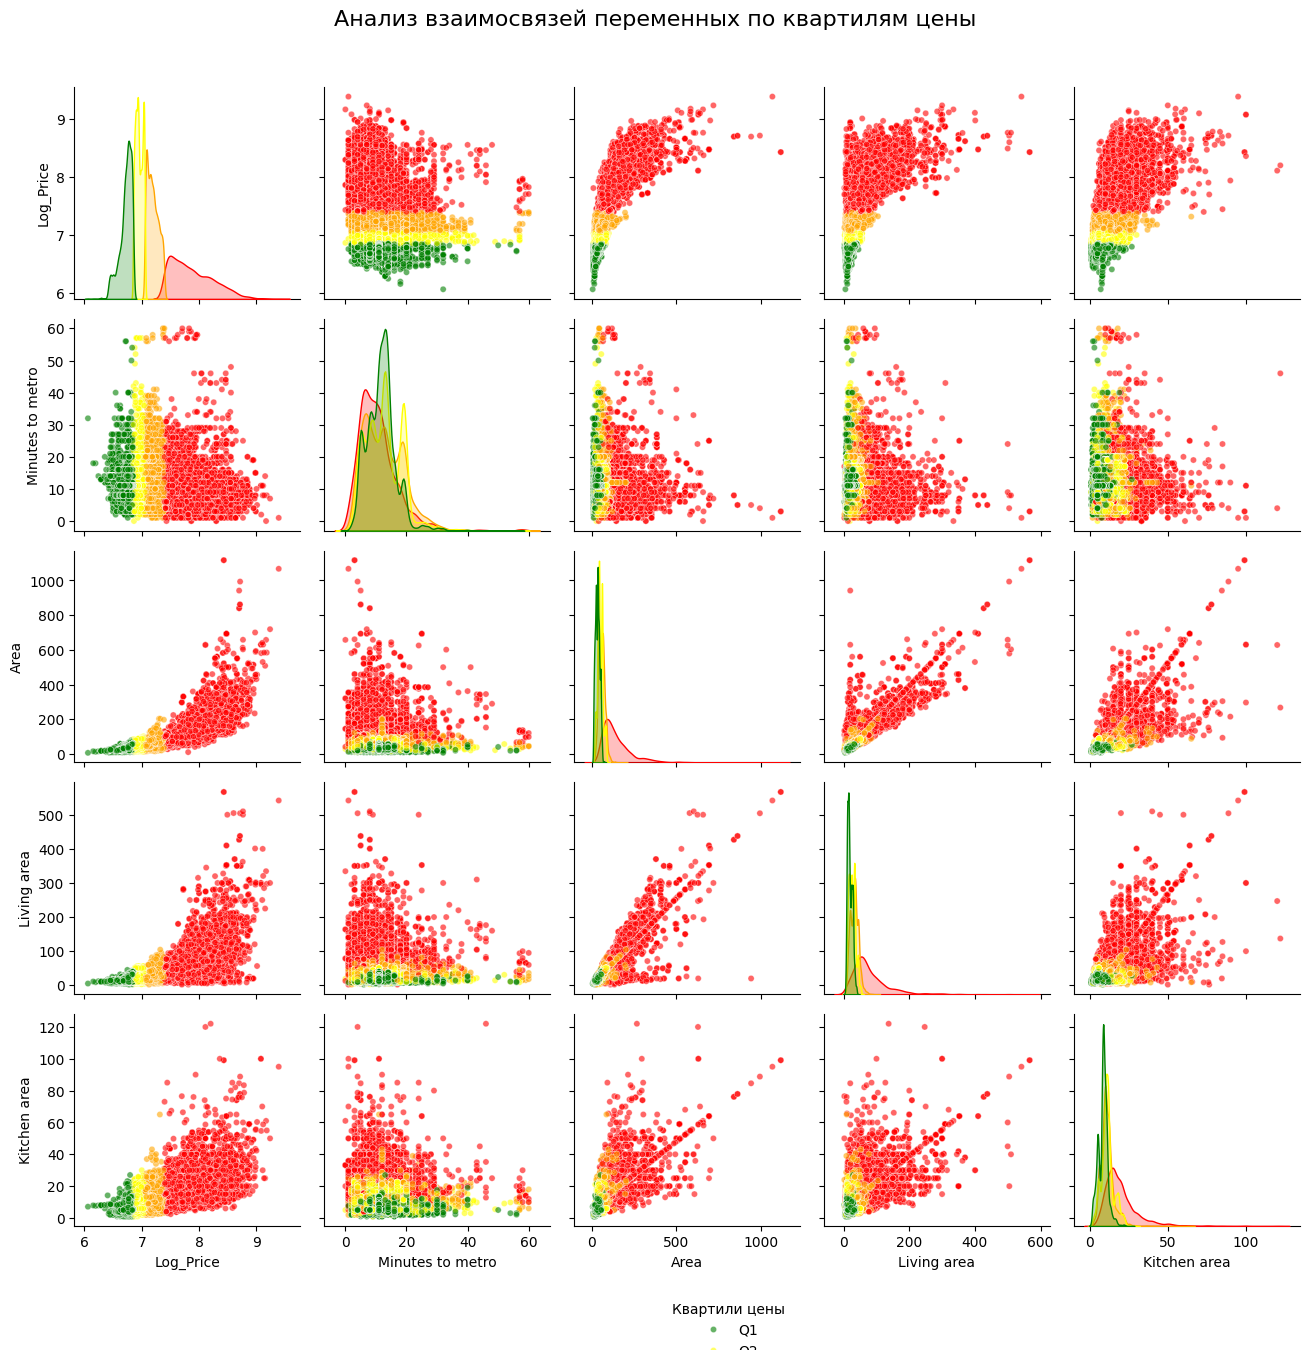

In [ ]:
pair_plot = sns.pairplot(df[['Log_Price', 'Minutes to metro', 'Area', 'Living area', 'Kitchen area', 'Quartile']],
                 hue='Quartile',
                 palette=['green', 'yellow', 'orange', 'red'], #покрасим квартили от зеленого к красному в зависимости от цены
                 plot_kws={'s': 20, 'alpha': 0.6})


pair_plot._legend.set_bbox_to_anchor((0.5, -0.05))
pair_plot._legend.set_title('Квартили цены')
pair_plot._legend.set_loc('lower left')

plt.suptitle('Анализ взаимосвязей переменных по квартилям цены', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

По графикам можно предположить, что большинство признаков имеют прямую связь с целевой. Кластеризация по расстоянию до метро менее выражена. Кроме того, наибольший разброс по всем признакам наблюдается в группе наиболее дорогих квартир.

Посмотрим на распределение цены в зависимости от дискретных данных.

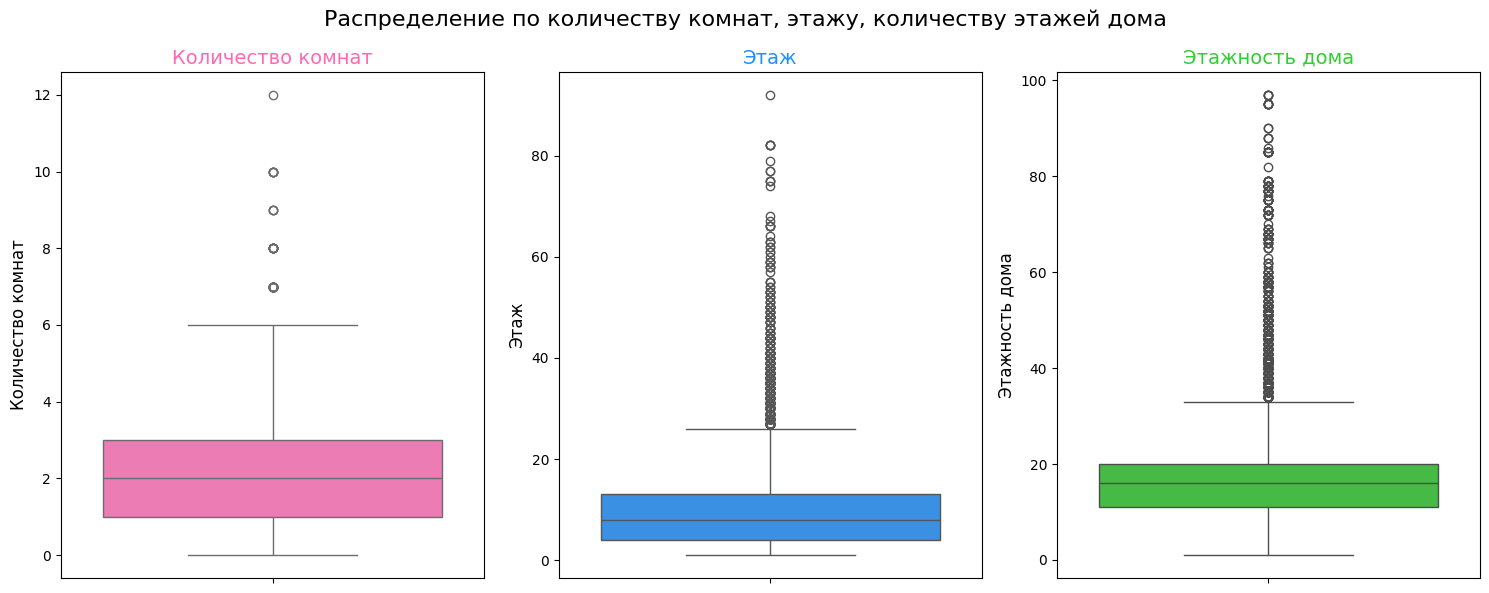

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
plt.suptitle('Распределение по количеству комнат, этажу, количеству этажей дома', fontsize=16)

# Количество комнат
sns.boxplot(y=df['Number of rooms'], ax=axes[0], color=dark_pastel_palette[0])
axes[0].set_title('Количество комнат', fontsize=14, color=dark_pastel_palette[0])
axes[0].set_ylabel('Количество комнат', fontsize=12)

# Этаж
sns.boxplot(y=df.Floor, ax=axes[1], color=dark_pastel_palette[1])
axes[1].set_title('Этаж', fontsize=14, color=dark_pastel_palette[1])
axes[1].set_ylabel('Этаж', fontsize=12)

# Количество этажей дома
sns.boxplot(y=df['Number of floors'], ax=axes[2], color=dark_pastel_palette[2])
axes[2].set_title('Этажность дома', fontsize=14, color=dark_pastel_palette[2])
axes[2].set_ylabel('Этажность дома', fontsize=12)

plt.tight_layout()
plt.show()

Видно, что преобладают дома до 20 этажей и 1-3 комнатные квартиры. Можно предположить, что выбросы по этим признакам будут также связаны и с выбросами цены, но зависимости проверим на этапе проверки гипотез. Сохраним статистики для всех переменных в таблицу.

In [ ]:
stats_df = add_statistics_to_table(stats_df, df['Minutes to metro'], 'Минут до метро')
stats_df = add_statistics_to_table(stats_df, df['Area'], 'Площадь квартиры')
stats_df = add_statistics_to_table(stats_df, df['Living area'], 'Жилая площадь')
stats_df = add_statistics_to_table(stats_df, df['Kitchen area'], 'Площадь кухни')
stats_df = add_statistics_to_table(stats_df, df['Number of rooms'], 'Количество комнат')
stats_df = add_statistics_to_table(stats_df, df['Floor'], 'Этаж')
stats_df = add_statistics_to_table(stats_df, df['Number of floors'], 'Количество этажей дома')

stats_df

,Стоимость,Логарифм стоимости,Минут до метро,Площадь квартиры,Жилая площадь,Площадь кухни,Количество комнат,Этаж,Количество этажей дома
Среднее,36121321.82,7.18,11.89,71.97,38.52,12.59,2.04,9.19,16.56
Дисперсия,6860082363567080.00,0.23,38.50,4674.27,1453.46,59.72,2.32,57.00,95.63
Мода,13500000.00,7.13,13.00,38.00,20.00,10.00,2.00,2.00,20.00
Медиана,11343200.00,7.05,11.00,53.30,28.50,10.60,2.00,8.00,16.00
1-й квартиль,7068116.00,6.85,7.00,37.40,17.60,8.60,1.00,4.00,11.00
2-й квартиль,11343200.00,7.05,11.00,53.30,28.50,10.60,2.00,8.00,16.00
3-й квартиль,24799247.50,7.39,15.00,77.14,43.20,14.50,3.00,13.00,20.00
4-й квартиль,2455020000.00,9.39,60.00,1117.00,566.80,122.00,12.00,92.00,97.00


**Для площади кватиры и площади гостиной наблюдается достаточно высокая дисперсия, а вот площадь кухни имеет не такой большой разброс. Кроме того, видно, как отличаются шкалы у признаков: площадь квартиры доходит до тысяч, а количество этажей до 12. Так как планируем регрессионный анализ, стоит подумать о нормализации признаков во избежание неравномерно больших коэффициентов.**

Посмотрим на корреляции между признаками

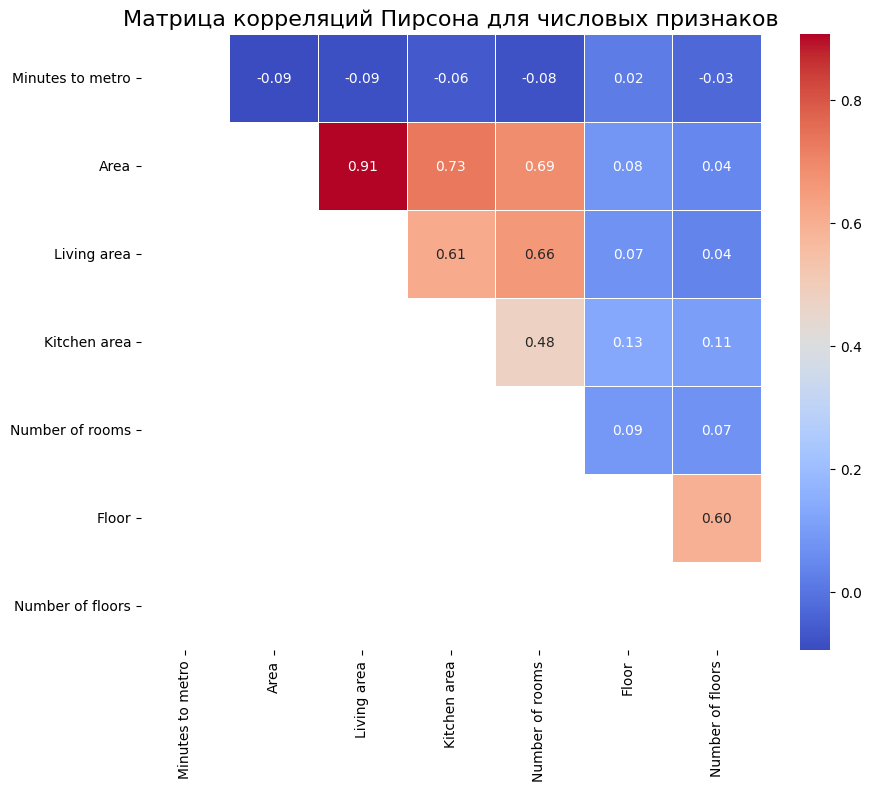

In [ ]:
data = df[['Minutes to metro', 'Area', 'Living area', 'Kitchen area',
           'Number of rooms', 'Floor', 'Number of floors']]

corr = data.corr('pearson')


mask = np.tril(np.ones_like(corr, dtype=bool))  # маска для нижней части матрицы, чтобы не дублировать отображение для пар признаков
corr_tri = corr.mask(mask)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_tri, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Матрица корреляций Пирсона для числовых признаков', fontsize=16)
plt.show()

Как можно было предположить логически, есть сильно и средне скоррелированные признаки: общая площадь и площадь кухни, общая площадь и жилая площадь, количество комнат и общая площадь, жилая площадь и количество комнат. Кроме того, использованный коэффициент Пирсона может давать неточные оценки корреляции для дискретных данных, поэтому посмотрим на корреляцию Спирмана.

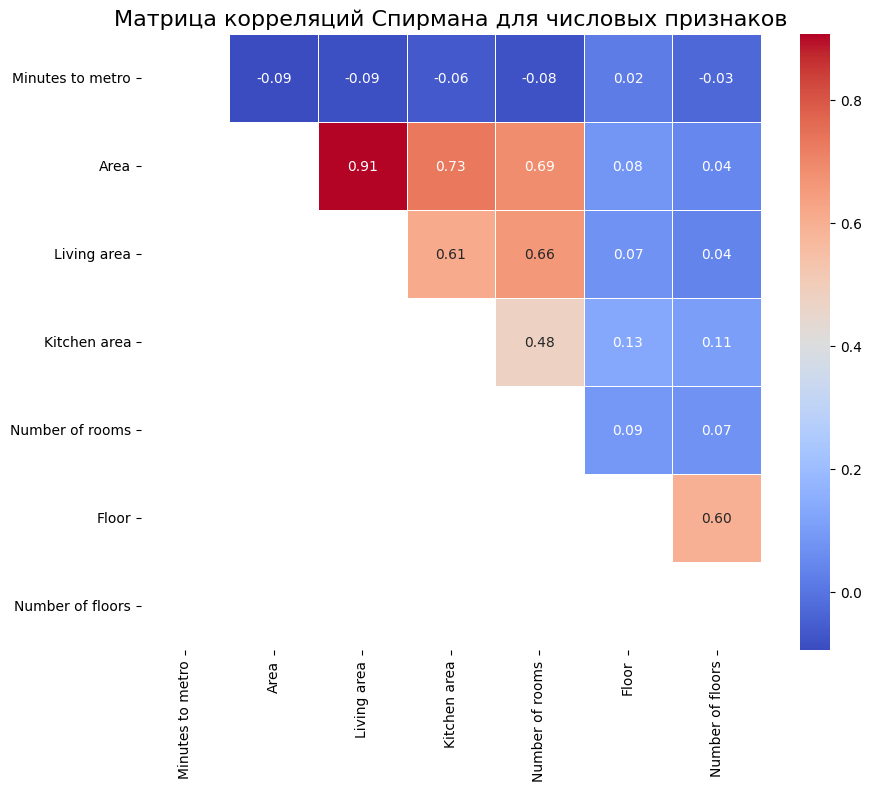

In [ ]:
corr = data.corr('spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_tri, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Матрица корреляций Спирмана для числовых признаков', fontsize=16)
plt.show()

In [ ]:
#расчет корреляций
pairs = [
    ('Area', 'Kitchen area'),
    ('Area', 'Living area'),
    ('Area', 'Number of rooms'),
    ('Living area', 'Number of rooms'),
    ('Living area', 'Kitchen area'),
    ('Number of rooms', 'Kitchen area')
]

for pair in pairs:
    print(f"\nАнализ пары: {pair[0]} и {pair[1]}")
    a = df[pair[0]]
    b = df[pair[1]]

    print("Корреляция Спирмана:")
    spearman(a, b)

    print("Корреляция Пирсона:")
    pearson(a, b)



Анализ пары: Area и Kitchen area
Корреляция Спирмана:
Коэффициент корреляции Спирмана: 0.6747
p-value: 0.0
Корреляция Пирсона:
Коэффициент корреляции Пирсона: 0.732
p-value: 0.0

Анализ пары: Area и Living area
Корреляция Спирмана:
Коэффициент корреляции Спирмана: 0.9054
p-value: 0.0
Корреляция Пирсона:
Коэффициент корреляции Пирсона: 0.9066
p-value: 0.0

Анализ пары: Area и Number of rooms
Корреляция Спирмана:
Коэффициент корреляции Спирмана: 0.8278
p-value: 0.0
Корреляция Пирсона:
Коэффициент корреляции Пирсона: 0.6871
p-value: 0.0

Анализ пары: Living area и Number of rooms
Корреляция Спирмана:
Коэффициент корреляции Спирмана: 0.7916
p-value: 0.0
Корреляция Пирсона:
Коэффициент корреляции Пирсона: 0.6576
p-value: 0.0

Анализ пары: Living area и Kitchen area
Корреляция Спирмана:
Коэффициент корреляции Спирмана: 0.4546
p-value: 0.0
Корреляция Пирсона:
Коэффициент корреляции Пирсона: 0.61
p-value: 0.0

Анализ пары: Number of rooms и Kitchen area
Корреляция Спирмана:
Коэффициент коррел

Оценки практически идентичны, статистически значимы. Необходимо будет учитывать в регрессии мультиколлинеарность и применить методы борьбы с ней.

Рассмотрим категориальные признаки: тип квартиры, станция метро, регион, ремонт

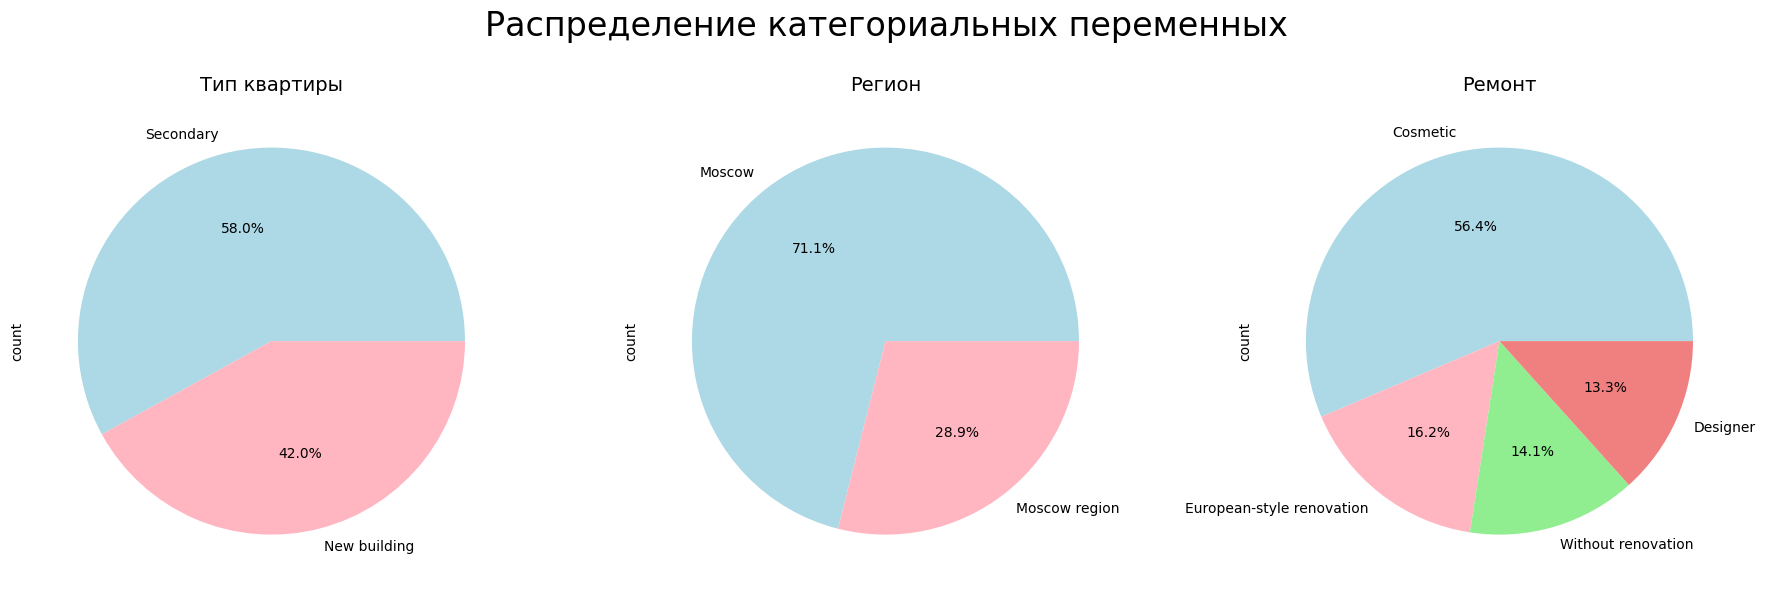

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

df['Apartment type'].value_counts().plot.pie(autopct='%1.1f%%', colors=light_pastel_colors, ax=axes[0])
axes[0].set_title('Тип квартиры', fontsize=14)
# axes[0].set_ylabel('')

df['Region'].value_counts().plot.pie(autopct='%1.1f%%', colors=light_pastel_colors, ax=axes[1])
axes[1].set_title('Регион', fontsize=14)
# axes[1].set_ylabel('')


df['Renovation'].value_counts().plot.pie(autopct='%1.1f%%', colors=light_pastel_colors, ax=axes[2])
axes[2].set_title('Ремонт', fontsize=14)
# axes[2].set_ylabel('')

plt.suptitle('Распределение категориальных переменных\n', fontsize=24)


plt.tight_layout()
plt.show()

Отдельно стоит отметить, что станций метро слишком много, чтобы анализировать каждую из них.

In [ ]:
df['Metro station'].nunique()

547

In [ ]:
#некоторые станции записаны с пробелами в названии в начале или в конце, удалим
df['Metro station'] = df['Metro station'].str.strip()

In [ ]:
#некоторые станции записаны по-разному, отредактируем
replace_dict = {
    'Международная': 'Москва-Сити',
    'Библиотека и Ленина': 'Библиотека им. Ленина',
    'Карамышевская': 'Мнёвники',
    'Бунинская аллея': 'Бунинская Аллея',
    'Щелковская': 'Щёлковская',
    'Хорошево': 'Хорошёво',
    'Молодежная': 'Молодёжная',
    'Тропарево': 'Тропарёво',
    'Савеловская': 'Савёловская',
    'Новые Черемушки' : 'Новые Черёмушки',
    'Рабочий посёлок' : 'Рабочий Посёлок',
    'Верхние котлы': 'Верхние Котлы',
    'Марьина Роща (Шереметьевская)' : 'Марьина Роща',
    'Теплый Стан' : 'Тёплый Стан',
    'Варшавская (Коломенское)' : 'Варшавская',
    'Филевский парк' : 'Филёвский парк',
    'Соколиная гора' : 'Соколиная Гора',
    'Воробьевы горы' : 'Воробьёвы Горы',
    'Воробьевы Горы' : 'Воробьёвы Горы',
    'Воробьёвы горы' : 'Воробьёвы Горы',
    'Шоссе энтузиастов': 'Шоссе Энтузиастов',
    'Парк культуры': 'Парк Культуры',
    'Битцевский парк': 'Битцевский Парк',
    'Петровский парк': 'Петровский Парк',
    'Семеновская': 'Семёновская',
    'Терехово (Мнёвники)': 'Терехово',

}


df['Metro station'] = df['Metro station'].replace(replace_dict)

In [ ]:
df['Metro station'].nunique()

295

Таким образом, получили данные гораздо чище. Используя внешние ресурсы, найдем данные по округам и станциям, агрегируем, получим:

In [ ]:
districts = {
    "Восточный округ": [
        "Авиамоторная", "Андроновка", "Белокаменная", "Бульвар Рокоссовского",
        "Выхино", "Измайлово", "Измайловская", "Кусково", "Локомотив",
        "Лухмановская", "Митьково", "Новогиреево", "Новокосино",
        "Партизанская", "Первомайская", "Перово", "Преображенская площадь",
        "Семёновская", "Соколиная Гора", "Сокольники", "Улица Дмитриевского",
        "Черкизовская", "Шоссе Энтузиастов", "Щёлковская", "Электрозаводская"
    ],
    "Красногорск": [
        "Опалиха", "Павшино", "Нахабино", "Красногорская", "Аникеевка"
    ],
    "Подольск": [
        "Подольск", "Силикатная"
    ],
    "Долгопрудный": [
        "Хлебниково", "Долгопрудная"
    ],
    "Одинцово": [
        "Немчиновка", "Сколково"
    ],
    "Ленинский": [
        "Битца"
    ],
    "Западный округ": [
        "Аминьевская", "Аэропорт Внуково", "Багратионовская", "Боровское шоссе",
        "Давыдково", "Киевская", "Кропоткинская", "Крылатское", "Кунцевская",
        "Кутузовская", "Ломоносовский проспект", "Матвеевская", "Мещерская",
        "Минская", "Мичуринский проспект", "Мякинино", "Молодёжная", "Новаторская",
        "Новопеределкино", "Озёрная", "Очаково", "Парк Победы", "Переделкино",
        "Пионерская", "Поклонная", "Проспект Вернадского", "Рабочий Посёлок",
        "Раменки", "Сетунь", "Славянский бульвар", "Солнечная", "Солнцево",
        "Студенческая", "Тропарёво", "Филёвский парк", "Фили", "Юго-Западная"
    ],
    "Зеленоградский округ": [
        "Зеленоград — Крюково"
    ],
    "Новомосковский округ": [
        "Внуково", "Говорово", "Кокошкино", "Коммунарка", "Корниловская",
        "Крёкшино", "Мичуринец", "Новомосковская", "Ольховая", "Остафьево",
        "Потапово", "Прокшино", "Пыхтино", "Рассказовка", "Румянцево",
        "Саларьево", "Санино", "Толстопальцево", "Тютчевская", "Филатов Луг",
        "Щербинка"
    ],
    "Северный округ": [
        "Аэропорт", "Балтийская", "Беговая", "Беломорская", "Бескудниково",
        "Верхние Лихоборы", "Водный стадион", "Войковская", "Гражданская",
        "Грачёвская", "Дегунино", "Динамо", "Дмитровская", "Зорге", "Коптево",
        "Красный Балтиец", "Лихоборы", "Марк", "Молжаниново", "Москва-Сити",
        "Моссельмаш", "Новоподрезково", "Окружная", "Панфиловская",
        "Петровский Парк", "Петровско-Разумовская", "Полежаевская",
        "Речной вокзал", "Селигерская", "Сокол", "Стрешнево",
        "Тимирязевская", "Ховрино", "Хорошёво", "Хорошёвская", "ЦСКА",
        "Яхромская"
    ],
    "Северо-Восточный округ": [
        "Алексеевская", "Алтуфьево", "Бабушкинская", "Бибирево",
        "Ботанический сад", "Бутырская", "ВДНХ", "Владыкино",
        "Выставочный центр", "Лианозово", "Марьина Роща", "Медведково",
        "Окружная", "Останкино", "Отрадное", "Ростокино", "Савёловская",
        "Свиблово", "Телецентр", "Улица Академика Королёва",
        "Улица Милашенкова", "Улица Сергея Эйзенштейна", "Физтех",
        "Фонвизинская", "Новодачная"
    ],
    "Северо-Западный округ": [
        "Волоколамская", "Митино", "Мнёвники", "Народное Ополчение",
        "Октябрьское поле", "Пенягино", "Планерная", "Пятницкое шоссе",
        "Спартак", "Строгино", "Сходненская", "Терехово", "Трикотажная",
        "Тушинская", "Щукинская"
    ],
    "Центральный округ": [
        "Александровский сад", "Арбатская", "Баррикадная", "Бауманская",
        "Беговая", "Белорусская", "Библиотека им. Ленина", "Боровицкая",
        "Воробьёвы Горы", "Выставочная", "Деловой центр", "Добрынинская", "Достоевская",
        "Китай-город", "Комсомольская", "Краснопресненская", "Красносельская",
        "Красные ворота", "Крестьянская застава", "Кузнецкий мост", "Курская",
        "Лубянка", "Лужники", "Марксистская", "Маяковская", "Менделеевская",
        "Москва-Сити", "Новокузнецкая", "Новослободская", "Октябрьская",
        "Охотный ряд", "Павелецкая", "Парк Культуры", "Площадь Ильича",
        "Площадь Революции", "Площадь трёх вокзалов", "Полянка",
        "Пролетарская", "Проспект Мира", "Пушкинская", "Рижская", "Римская",
        "Серп и Молот", "Серпуховская", "Смоленская", "Спортивная",
        "Сретенский бульвар", "Сухаревская", "Таганская", "Тверская",
        "Театральная", "Тестовская", "Третьяковская", "Трубная",
        "Тургеневская", "Улица 1905 года", "Фрунзенская", "Цветной бульвар",
        "Чеховская", "Чистые пруды", "Чкаловская", "Шелепиха",
        "Электрозаводская"
    ],
    "Юго-Восточный округ": [
        "Авиамоторная", "Андроновка", "Братиславская", "Волгоградский проспект",
        "Волжская", "Выхино", "Депо", "Дубровка", "Жулебино", "Калитники",
        "Кожуховская", "Косино", "Котельники", "Кузьминки", "Курьяново",
        "Лермонтовский проспект", "Лефортово", "Люблино", "Марьино",
        "Москва-Товарная", "Некрасовка", "Нижегородская", "Новохохловская",
        "Окская", "Перерва", "Печатники", "Плющево", "Рязанский проспект",
        "Сортировочная", "Стахановская", "Текстильщики", "Угрешская",
        "Чухлинка", "Юго-Восточная", "Вешняки"
    ],
    "Юго-Западный округ": [
        "Академическая", "Беляево", "Битцевский Парк", "Бульвар Адмирала Ушакова",
        "Бульвар Дмитрия Донского", "Бунинская Аллея", "Бутово", "Воронцовская",
        "Генерала Тюленева", "Зюзино", "Калужская", "Каховская", "Коньково",
        "Нахимовский проспект", "Новаторская", "Новоясеневская",
        "Новые Черёмушки", "Площадь Гагарина", "Профсоюзная", "Севастопольская",
        "Тёплый Стан", "Улица Горчакова", "Улица Скобелевская",
        "Улица Старокачаловская", "Университет", "Университет Дружбы Народов",
        "Ясенево"
    ],
    "Южный округ": [
        "Автозаводская", "Алма-Атинская", "Аннино", "Борисово", "Варшавская",
        "Верхние Котлы", "Домодедовская", "ЗИЛ", "Зябликово", "Кантемировская",
        "Каширская", "Кленовый бульвар", "Коломенская", "Красногвардейская",
        "Красный Строитель", "Крымская", "Ленинский проспект", "Лесопарковая",
        "Москворечье", "Нагатинская", "Нагатинский Затон", "Нагорная",
        "Орехово", "Покровское", "Пражская", "Технопарк", "Тульская",
        "Улица Академика Янгеля", "Царицыно", "Чертановская", "Шаболовская",
        "Шипиловская", "Южная"
    ]
}

In [ ]:
# Создим новый столбец 'district' и будем использовать его значения в регрессии

def find_district(station):
    for district, stations in districts.items():
        if station in stations:
            return district
    return "Неизвестный округ"

df['district'] = df['Metro station'].apply(find_district)

###**Выводы**

**Несколько факторов в наборе имеют высокую корреляцию. Высокая корреляция между факторами "раздувает" дисперсию оценок коэффициентов, оценки могут быть неустойчивы. Если оставить такие регрессоры в модели, стоит ожидать широкие доверительные интервалы. Необходимо оценить мультиколлинеарность с помощью метрик: рассчитаем VIF для факторов в ходе регрессионного анализа и примем решение о регуляризации.**

**Кроме того, есть категориальные данные, влияние которых оценить достаточно сложноЭ, но они могут оказывать эффект на характер распределения целевой переменной. Необходимо оценить, как распределение по категориальным данным влияет на распределение целевой переменной**

#**Постановка гипотез и статистический анализ**

Первое очевидное предположение, которое возникает при анализе - стоимость квартир для Москвы и Московской области должна отличаться. Также интуитивно можно предположить, что распределения для вторичного и первичного жилья, а также распределения по станциям метро и ремонту будут отличаться. Таким образом, сегментируем набор данных по категориальным переменным и сравним сегменты между собой.

Кроме того, необходимо учесть особенности распределения цены и нелинейные преобразования, которые производились над целевой переменной. Проведем тест на нормальность, чтобы корректно сформулировать гипотезы и подобрать статистические тесты.

##**Проверка распределения стоимости на нормальность и подбор статистических тестов**

In [ ]:
normal_or_not(df.Price.values, test = 'Shapiro')

W_statistic: 0.379 
 w_p_val: 0.0
Выборочное распределение не подчиняется нормальному закону по тесту Шапиро-Уилка.


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22676.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
normal_or_not(df.Price.values, test = 'KS')

W_statistic: 0.342 
 w_p_val: 0.0
Выборочное распределение не подчиняется нормальному закону по тесту Колмогорова-Смирнова.


 Несмотря на то, что логарифмирование приближает распределение к нормальному, всё же распределение Log_Price отличается от нормального, что можно определить как графически, как и по тестам

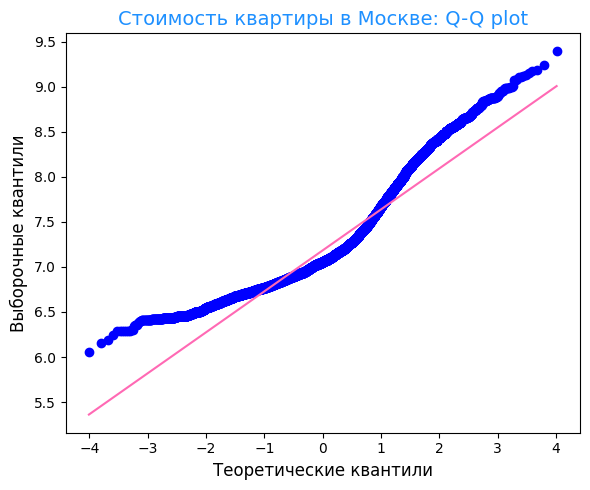

In [ ]:
plt.figure(figsize=(6, 5))
sts.probplot(df.Log_Price, dist="norm", plot=plt)

#покрасим кастомно
line = plt.gca().get_lines()[1]
line.set_markerfacecolor(dark_pastel_palette[1])
line.set_markeredgecolor(dark_pastel_palette[1])
line.set_color(dark_pastel_palette[0])


plt.title('Стоимость квартиры в Москве: Q-Q plot', color=dark_pastel_palette[1], fontsize=14)
plt.xlabel('Теоретические квантили', fontsize=12)
plt.ylabel('Выборочные квантили', fontsize=12)


plt.ticklabel_format(style='plain', axis='both')

plt.tight_layout()
plt.show()

In [ ]:
normal_or_not(df.Log_Price.values, test = 'KS')

W_statistic: 0.13 
 w_p_val: 0.0
Выборочное распределение не подчиняется нормальному закону по тесту Колмогорова-Смирнова.


In [ ]:
normal_or_not(df.Log_Price.values, test = 'Shapiro')

W_statistic: 0.904 
 w_p_val: 0.0
Выборочное распределение не подчиняется нормальному закону по тесту Шапиро-Уилка.


**Таким образом, методы, основанные на средних, будут показывать нестабильные и сложноинтерпретируемые результаты для цены. Независимо от того, какой таргет анализировать - исходный или логарифм, стоит ожидать лучших результатов от непараметрических тестов. Так как от логарифма целевой переменной ожидаем большую стабильность, также этот вид таргета имеет меньшую дисперсию, будем далее использовать Log_Price.**


##**Анализ сегментов**

In [ ]:
df['Apartment type'].unique()

array(['Secondary', 'New building'], dtype=object)

In [ ]:
a = df[df['Apartment type'] == 'New building']['Log_Price'].values
b = df[df['Apartment type'] == 'Secondary']['Log_Price'].values

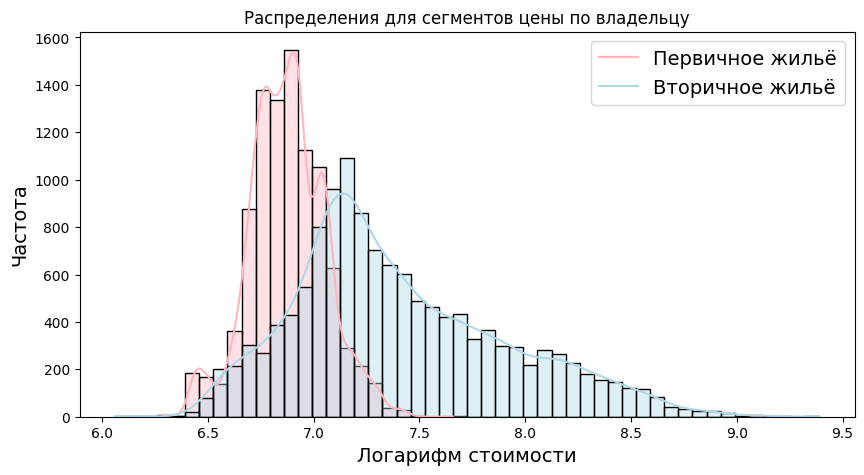

In [ ]:
#построим распределения на одной шкале
plt.figure(figsize=(10, 5))

bin_range = (min(min(a), min(b)), max(max(a), max(b)))

sns.histplot(a, color=light_pastel_colors[1], bins = 50, binrange=bin_range, kde=True, alpha=0.4)
sns.histplot(b, color=light_pastel_colors[0], bins = 50, binrange=bin_range, kde=True, alpha=0.4)
plt.legend(['Первичное жильё','Вторичное жильё'], fontsize=14)
plt.title('Распределения для сегментов цены по владельцу')
plt.xlabel('Логарифм стоимости', fontsize=14)
plt.ylabel('Частота', fontsize=14)

plt.show()

Визуально наблюдаются отличия распределений друг от друга, однако возможно, что они отличаются только параметрами сдвига.

In [ ]:
df['Region'].unique()

array(['Moscow region', 'Moscow'], dtype=object)

In [ ]:
a1 = df[df['Region'] == 'Moscow region']['Log_Price'].values
b1 = df[df['Region'] == 'Moscow']['Log_Price'].values

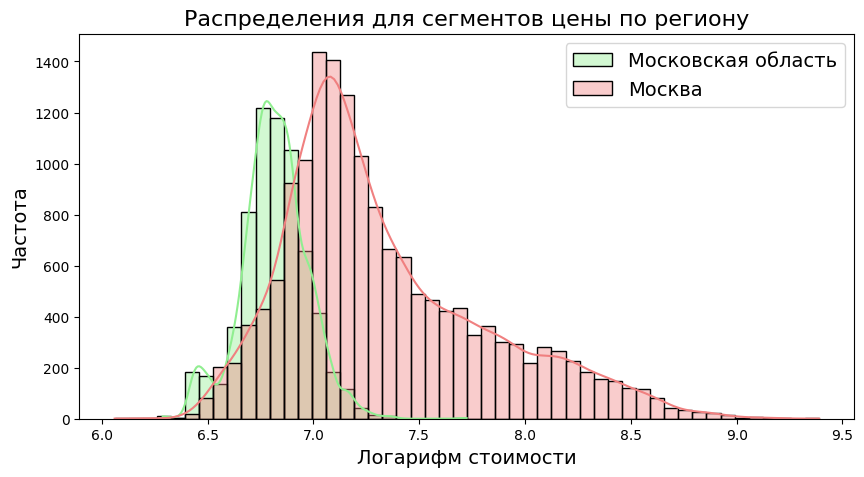

In [ ]:
#построим распределения на одной шкале
plt.figure(figsize=(10, 5))

bin_range = (min(min(a), min(b)), max(max(a), max(b)))

sns.histplot(a1, color=light_pastel_colors[2], bins=50, binrange=bin_range, kde=True, alpha=0.4, label='Московская область')
sns.histplot(b1, color=light_pastel_colors[3], bins=50, binrange=bin_range, kde=True, alpha=0.4, label='Москва')

plt.legend(fontsize=14)
plt.title('Распределения для сегментов цены по региону', fontsize=16)
plt.xlabel('Логарифм стоимости', fontsize=14)
plt.ylabel('Частота', fontsize=14)

plt.show()

Распределения очень похожи, визуально отличаются лишь сдвигом.

In [ ]:
df['Renovation'].unique()

array(['Cosmetic', 'European-style renovation', 'Without renovation',
       'Designer'], dtype=object)

In [ ]:
a2 = df[df['Renovation'] == 'Without renovation']['Log_Price'].values
b2 = df[df['Renovation'] == 'Cosmetic']['Log_Price'].values
c = df[df['Renovation'] == 'European-style renovation']['Log_Price'].values
d = df[df['Renovation'] == 'Designer']['Log_Price'].values

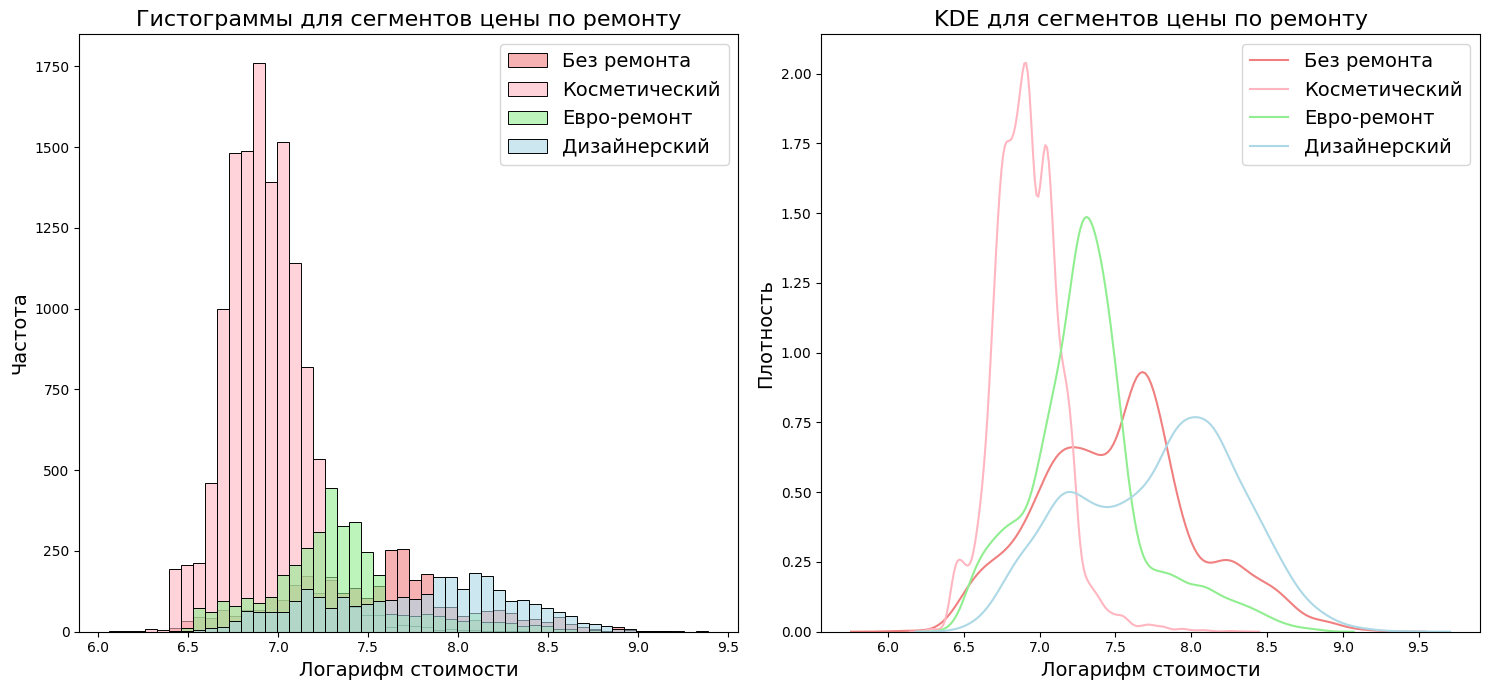

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

bin_range = (min(min(a), min(b), min(c), min(d)), max(max(a), max(b), max(c), max(d)))

sns.histplot(a2, color=light_pastel_colors[3], bins=50, binrange=bin_range, alpha=0.6, label='Без ремонта', ax=ax1)
sns.histplot(b2, color=light_pastel_colors[1], bins=50, binrange=bin_range, alpha=0.6, label='Косметический', ax=ax1)
sns.histplot(c, color=light_pastel_colors[2], bins=50, binrange=bin_range, alpha=0.6, label='Евро-ремонт', ax=ax1)
sns.histplot(d, color=light_pastel_colors[0], bins=50, binrange=bin_range, alpha=0.6, label='Дизайнерский', ax=ax1)

ax1.legend(fontsize=14)
ax1.set_title('Гистограммы для сегментов цены по ремонту', fontsize=16)
ax1.set_xlabel('Логарифм стоимости', fontsize=14)
ax1.set_ylabel('Частота', fontsize=14)

sns.kdeplot(a2, color=light_pastel_colors[3], label='Без ремонта', ax=ax2)
sns.kdeplot(b2, color=light_pastel_colors[1], label='Косметический', ax=ax2)
sns.kdeplot(c, color=light_pastel_colors[2], label='Евро-ремонт', ax=ax2)
sns.kdeplot(d, color=light_pastel_colors[0], label='Дизайнерский', ax=ax2)

ax2.legend(fontsize=14)
ax2.set_title('KDE для сегментов цены по ремонту', fontsize=16)
ax2.set_xlabel('Логарифм стоимости', fontsize=14)
ax2.set_ylabel('Плотность', fontsize=14)

plt.tight_layout()
plt.show()

Для групп по ремонту различия более выражены, в том числе из-за дисбаланса сегментов: больше значений в группе с косметическим ремонтом. Интересно, что у квартир без ремонта также наблюдаются достаточно высокие значения цены, как у дизайнерского ремонта.

##**Выводы**

**Отметим характер данных в разных сегментах: так как мы оцениваем ценообразование, этот процесс практически идентичен по характеру, что визуально подтверждается на графиках. Таким образом, наиболее рациональным кажется применение по сегментам гипотез о происхождении из одного распределения, но с разными параметрами.**

##**Гипотезы для статистического анализа**

**H0(1)** Распределения стоимости квартир на первичном и вторичном рынке идентичны

**H0(2)** Распределения стоимости квартир в Москве и Московской области идентичны

**H0(3)** Распределения стоимости квартир по выполненному ремонту идентичны


###**Проверка Н0(1)** Распределения стоимости квартир на первичном и вторичном рынке идентичны

У обоих распределений "тяжелые" хвосты, распределения нельзя считать нормальными. Применим непараметрический критерий Уилкоксона-Манна-Уитни. Посчитаем критерий Колмогорова-Смирнова.
Дополнительно сравним с результатом ttest, хотя ожидаем от него плохую интерпретируемость в связи с тяжелыми хвостами распределения.


In [ ]:
_, pvalue = sts.mannwhitneyu(a, b, alternative='two-sided')
print(f'Согласно тесту Мана-Уитни pvalue = {round(pvalue, 5)}')

Согласно тесту Мана-Уитни pvalue = 0.0


In [ ]:
_, p_value = ks_2samp(a, b)
print(f'Согласно тесту Колмогорова-Смирнова pvalue = {round(pvalue, 5)}')

Согласно тесту Колмогорова-Смирнова pvalue = 0.0


In [ ]:
  _, p_val = sts.ttest_ind(a, b, equal_var = False)
  print(f'Согласно ttest pvalue = {round(pvalue, 5)}')

Согласно ttest pvalue = 0.0


Таким образом, Н0 можно отвергнуть. Построим 95% доверительный интервал для медиан выборок на основе бутстреп, чтобы проверить

In [ ]:
efr_mean_diff(a, b)

95% эфронов интервал для разности медиан: (-0.43, -0.413)


####**Выводы**

**Н0 отвергнута. Доверительный интервал включает отрицательные значения, медиана первой группы (новостройки) статистически значимо меньше медианы второй группы (вторичное жилье). Кроме того, получен достаточно узкий доверительный интервал. Это может быть результатом логарифмирования, применённого к целевой переменной: дисперсия распределения была сильно снижена.**

###**Проверка Н0(2)**  Распределения стоимости квартир в Москве и Московской области идентичны

In [ ]:
_, pvalue = sts.mannwhitneyu(a1, b1, alternative='two-sided')
print(f'Согласно тесту Мана-Уитни pvalue = {round(pvalue, 5)}')

Согласно тесту Мана-Уитни pvalue = 0.0


In [ ]:
_, p_value = ks_2samp(a1, b1)
print(f'Согласно тесту Колмогорова-Смирнова pvalue = {round(pvalue, 5)}')

Согласно тесту Колмогорова-Смирнова pvalue = 0.0


In [ ]:
  _, p_val = sts.ttest_ind(a1, b1, equal_var = False)
  print(f'Согласно ttest pvalue = {round(pvalue, 5)}')


Согласно ttest pvalue = 0.0


In [ ]:
efr_mean_diff(a1, b1)

95% эфронов интервал для разности медиан: (-0.396, -0.379)


####**Выводы**

**Н0 отвергнута. Доверительный интервал включает отрицательные значения, медиана первой группы (Московская область) статистически значимо меньше медианы второй группы (Москва). Кроме того, получен достаточно узкий доверительный интервал. Это может быть результатом логарифмирования, применённого к целевой переменной: дисперсия распределения была сильно снижена.**


###**H0(3)** Распределения стоимости квартир по выполненному ремонту идентичны

Для нескольких групп применим непараметрический тест Краскела-Уоллиса для независимых выборок. Проверим результаты с помощью попарных сравнений.

In [ ]:
_, p_value = kruskal(a2, b2, c, d)
print(f'Согласно тесту Краскела-Уоллиса pvalue = {round(pvalue, 5)}')

Согласно тесту Краскела-Уоллиса pvalue = 0.0


In [ ]:
posthoc_result = sp.posthoc_dunn([a2, b2, c, d], p_adjust='bonferroni')

print(f"Результаты попарного сравнения по тесту Данна:\n{posthoc_result}")


Результаты попарного сравнения по тесту Данна:
     1    2    3    4
1 1.00 0.00 0.00 0.00
2 0.00 1.00 0.00 0.00
3 0.00 0.00 1.00 0.00
4 0.00 0.00 0.00 1.00


####**Выводы**

**Н0 отвергнута. Выявлены статистически значимые различия распределений между всеми группами попарно**

#**Регрессионный анализ**

##**Тест на мультиколлинеарность**

В данных были выявлены сильно скоррелированные переменные, поэтому проведём их оценку VIF, и получим, насколько дисперсия коэффициента регрессии увеличивается из-за мультиколлинеарности. Будем использовать информацию из открытых источников для интерпретации:

- VIF = 1: Нет мультиколлинеарности

- 1 < VIF < 5: Умеренная мультиколлинеарность (может быть допустимо)

- VIF >= 5: Сильная мультиколлинеарность

- VIF >= 10: Критическая мультиколлинеарность, необходимо устранить

In [ ]:
#выберем numeric колонки
num_columns = ['Minutes to metro', 'Number of rooms', 'Area', 'Living area', 'Kitchen area', 'Floor', 'Number of floors']

calculate_vif(df, num_columns)

,Variable,VIF
0,const,11.04
1,Minutes to metro,1.01
2,Number of rooms,1.93
3,Area,8.48
4,Living area,5.88
5,Kitchen area,2.27
6,Floor,1.57
7,Number of floors,1.57


Для Area получаем сильную мультиколлинеарность, как и предположили раньше в ходе корреляционного анализа. Однако этот критерий имеет важное значение.

Кстати, без этого параметра получаем удовлетворительный VIF для остальных регрессоров:

In [ ]:
#выберем numeric колонки без Area
columns_no_area = ['Minutes to metro', 'Number of rooms', 'Living area', 'Kitchen area', 'Floor', 'Number of floors']

calculate_vif(df, columns_no_area)

,Variable,VIF
0,const,10.80
1,Minutes to metro,1.01
2,Number of rooms,1.80
3,Living area,2.21
4,Kitchen area,1.64
5,Floor,1.57
6,Number of floors,1.56


Как и в случае, если убираем разделение на жилую и площадь кухни:

In [ ]:
#выберем numeric колонки без Area
columns_only_area = ['Minutes to metro', 'Number of rooms', 'Area', 'Floor', 'Number of floors']

calculate_vif(df, columns_only_area)

,Variable,VIF
0,const,9.76
1,Minutes to metro,1.01
2,Number of rooms,1.90
3,Area,1.90
4,Floor,1.57
5,Number of floors,1.56


Построим 3 версии модели:
- без оценки площади
- без разделения на жилую и площадь кухни, то есть только с критерием Area
- со всеми тремя параметрами, с применением регуляризации

##**Функции для тренировки регрессии и отображения её результатов**

In [ ]:
def show_reg_res(model: BaseEstimator, y: pd.Series, X: pd.DataFrame)-> None:
    '''Показывает результат регрессии'''

    pred_val = model.predict(X)

    # Рассчитываем метрики
    mse = mean_squared_error(y, pred_val)
    mae = mean_absolute_error(y, pred_val)
    r2 = r2_score(y, pred_val)


    print('\n ================================================== TRAIN RESULTS ================================================== \n')
    print(f'Mean Squared Error (MSE): {round(mse, 3)}')  # Используем round() для округления
    print(f'Mean Absolute Error (MAE): {round(mae, 3)}')
    print(f'R² Score: {round(r2, 3)}\n')


    # Создаем DataFrame для визуализации
    res_df = pd.DataFrame({
        'Predicted': pred_val,
        'Actual': y,
        'Residuals': y - pred_val  # Ошибки (остатки)
    })

    # Отрисовываем распределение ошибок
    plt.figure(figsize=(10, 5))
    sns.histplot(res_df['Residuals'], kde=True, color='blue')
    plt.title('Распределение ошибок (Residuals)')
    plt.xlabel('Ошибки')
    plt.ylabel('Частота')
    plt.show()

    # Отрисовываем предсказанные значения vs истинные значения
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=res_df['Actual'], y=res_df['Predicted'], color='green')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle='--', color='red')  # Линия идеальных предсказаний
    plt.title('Предсказанные значения vs Истинные значения')
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.show()

    # Отрисовываем остатки vs предсказанные значения
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=res_df['Predicted'], y=res_df['Residuals'], color='orange')
    plt.axhline(y=0, color='red', linestyle='--')  # Горизонтальная линия на уровне 0
    plt.title('Остатки vs Предсказанные значения')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.show()

In [ ]:
def train_model(
    dataset: pd.DataFrame,
    target: str,
    feature_names: List[str],
    show_results: bool = False,
    return_norm_tests: bool = False,
    robust: bool = False,
    alpha: float = 0.05
)-> Tuple[pd.DataFrame, BaseEstimator, pd.DataFrame]:
    '''Обучает линейную регрессионную модель и рассчитывает доверительные интервалы коэффициентов.'''

    dataset = dataset.copy()

    # Создадим матрицу фичей как фактор x1 и единичный вектор, на который будет фиттиться константа
    X = stm.add_constant(dataset[feature_names])

    # Зафитим модель на данные. y - наша целевая переменная, X - матрица факторов
    if robust:
        model = stm.OLS(dataset[target], X).fit(cov_type='HC0')
    else:
        model = stm.OLS(dataset[target], X).fit()

    # Сохраняем предсказанные значения и остатки
    dataset[f'{target}_hat'] = model.fittedvalues
    dataset['residuals'] = model.resid

     # Рассчитываем доверительные интервалы для коэффициентов
    conf_intervals = model.conf_int(alpha=alpha)
    conf_intervals.columns = ['lower', 'upper']  # Переименуем столбцы для удобства

    # Вывод результатов и графиков
    if show_results:
        print(model.summary())  # Вывод статистики модели
        show_reg_res(model, dataset[target], X)  # Используем нашу функцию show_res для визуализации

    # Проверка на нормальность остатков (если требуется)
    if return_norm_tests:
        print("\nПроверка нормальности остатков:")
        residuals_normalized = (dataset['residuals'] - np.mean(dataset['residuals'])) / np.std(dataset['residuals'])
        normal_or_not(residuals_normalized, test='Shapiro')  # Проверка с помощью теста Шапиро-Уилка
        normal_or_not(residuals_normalized, test='KS')  # Проверка с помощью теста Колмогорова-Смирнова

        # Визуализация: Q-Q plot и гистограмма
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sts.probplot(residuals_normalized, dist="norm", plot=plt)
        plt.title('Q-Q Plot')

        plt.subplot(1, 2, 2)
        sns.histplot(residuals_normalized, kde=True, color='blue', stat='density')
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = sts.norm.pdf(x, np.mean(residuals_normalized), np.std(residuals_normalized))
        plt.plot(x, p, 'r', linewidth=2)
        plt.title('Гистограмма с кривой нормального распределения')
        plt.show()

    return dataset, model, conf_intervals

##**Первая спецификация модели**

Построим модель на числовых признаках в качестве первой спецификации.

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     7640.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:36:46   Log-Likelihood:                -1700.2
No. Observations:               22676   AIC:                             3416.
Df Residuals:                   22668   BIC:                             3481.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.6297      0.006  

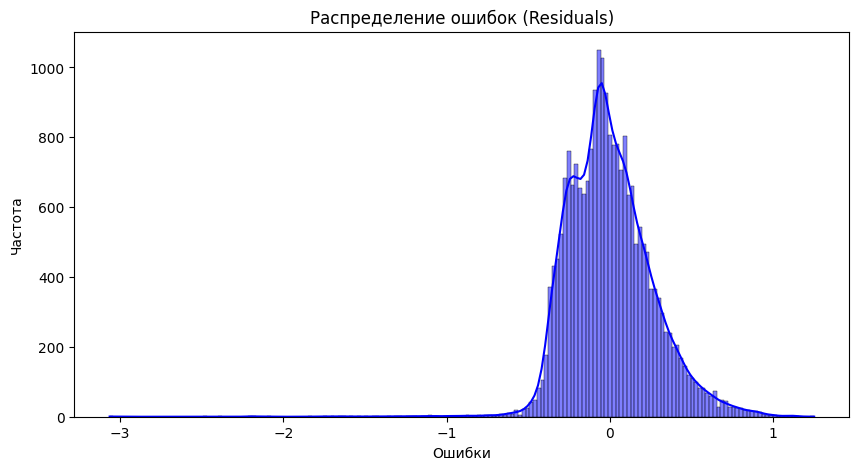

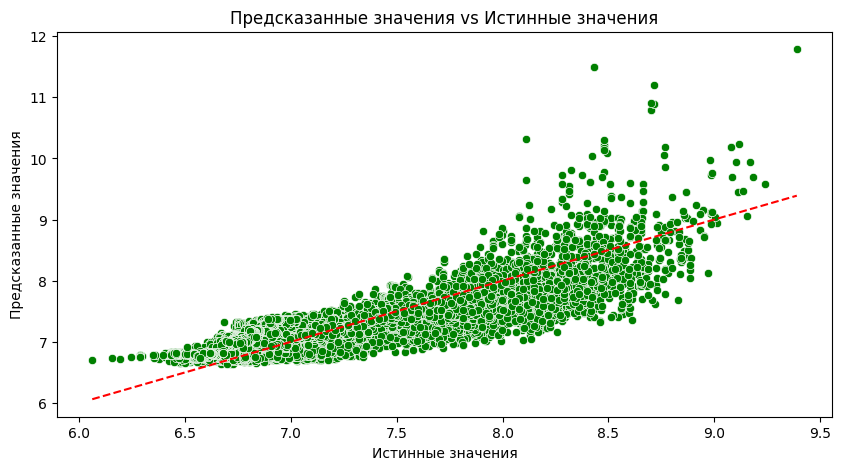

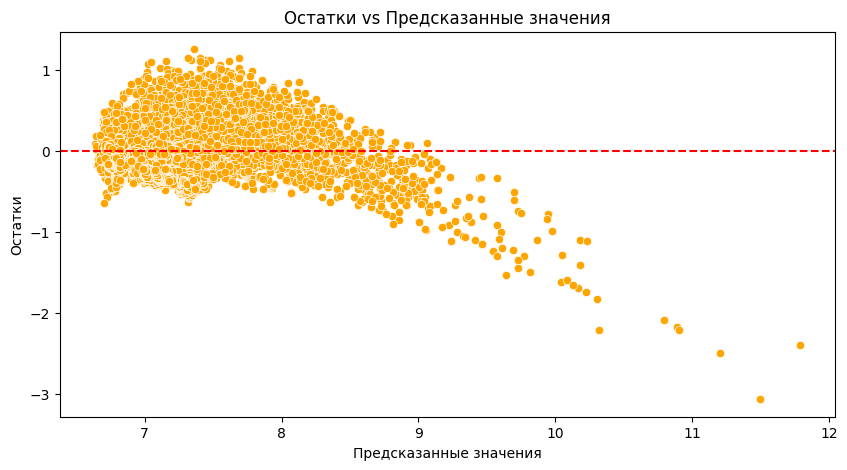


Проверка нормальности остатков:
W_statistic: 0.956 
 w_p_val: 0.0
Выборочное распределение не подчиняется нормальному закону по тесту Шапиро-Уилка.
W_statistic: 0.045 
 w_p_val: 0.0
Выборочное распределение не подчиняется нормальному закону по тесту Колмогорова-Смирнова.


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22676.
  res = hypotest_fun_out(*samples, **kwds)


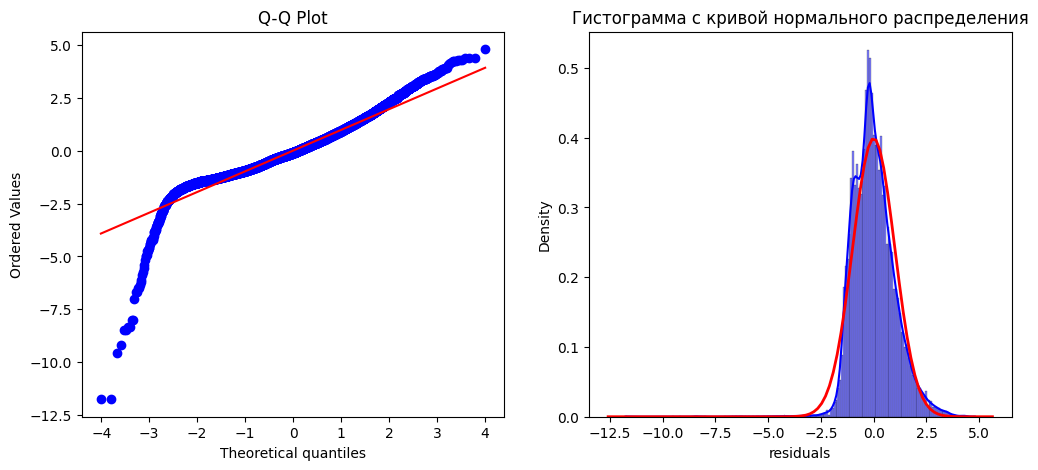

,lower,upper
const,6.62,6.64
Minutes to metro,-0.00,-0.00
Number of rooms,0.08,0.09
Area,0.00,0.00
Living area,0.00,0.00
Kitchen area,0.01,0.01
Floor,-0.00,-0.00
Number of floors,0.00,0.00


In [ ]:
dataset, model, conf_intervals = train_model(
    dataset=df,
    target='Log_Price',
    feature_names=num_columns,
    show_results=True,
    return_norm_tests=True,
    robust=False
)


conf_intervals

###**Выводы**

Модель объясняет 70.2% дисперсии целевой переменной, высокое значение F-статистики и p-значение (0.00) указывают на то, что модель в целом статистически значима.

Все коэффициенты имеют узкие доверительные интервалы, что указывает на их статистическую значимость.

Mean Squared Error (MSE): 0.068, Mean Absolute Error (MAE): 0.198. Оба показателя указывают на то, что модель имеет приемлемую точность, но есть возможности для улучшения.

**Проблемы:**
Остатки модели не распределены нормально, что может указывать на проблемы с моделью (например, пропущенные переменные или нелинейные зависимости): такой вывод получен по тестам Шапиро-Уилка, Колмогорова-Смирнова, а также дополнительным тестам Omnibus, Jarque-Bera. Однако остатки практически симметричны (Skew (асимметрия): 0.010). Остатки имеют тяжёлые хвосты (высокий эксцесс) согласно Kyrtosis 8.120

Durbin-Watson: 0.772, значение близко к 0 указывает на положительную автокорреляцию остатков. Это может быть связано с пропущенными временными или пространственными зависимостями.

Cond. No. (Condition Number): 381, умеренное значение, указывающее на возможную мультиколлинеарность. Однако коэффициенты модели остаются стабильными.

##**Тест на гетероскедастичность**

In [ ]:
residuals = model.resid
exog = model.model.exog
lm, lm_pvalue, fvalue, f_pvalue = het_white(residuals, exog)

print(f"LM-статистика: {lm}, p-значение: {lm_pvalue}")

LM-статистика: 12963.587922230594, p-значение: 0.0


Дисперсия остатков первой модели непостоянна. Таким образом, нужно пересмотреть используемые факторы и рассмотреть робастные оценки.

---



##**Кодирование категориальных признаков**

In [ ]:
# One-Hot Encoding для категориальных переменных
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(df[['district', 'Renovation', 'Region', 'Apartment type']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['district', 'Renovation', 'Region', 'Apartment type']))

encoded_df.head()

,district_Долгопрудный,district_Западный округ,district_Зеленоградский округ,district_Красногорск,district_Ленинский,district_Новомосковский округ,district_Одинцово,district_Подольск,district_Северный округ,district_Северо-Восточный округ,district_Северо-Западный округ,district_Центральный округ,district_Юго-Восточный округ,district_Юго-Западный округ,district_Южный округ,Renovation_Designer,Renovation_European-style renovation,Renovation_Without renovation,Region_Moscow region,Apartment type_Secondary
0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00
2,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00
4,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00


##**Нормализация числовых признаков**

In [ ]:
num_columns

['Minutes to metro',
 'Number of rooms',
 'Area',
 'Living area',
 'Kitchen area',
 'Floor',
 'Number of floors']

In [ ]:
#применим робастный метод
scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_columns]), columns=num_columns)

df_scaled.head()

,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors
0,-0.62,-0.50,-0.57,-0.68,-0.36,1.89,1.00
1,-1.12,-0.50,-0.10,-0.33,-0.10,-0.22,-0.11
2,0.38,-0.50,-0.22,-0.48,0.42,0.22,1.00
3,-0.38,-0.50,-0.46,-0.49,0.07,0.44,1.89
4,-0.62,-0.50,-0.39,-0.52,-1.12,-0.33,-1.22


In [ ]:
final_df = pd.concat([df_scaled, encoded_df, df[['Log_Price']]], axis=1)
final_df.head()

,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,district_Долгопрудный,district_Западный округ,district_Зеленоградский округ,...,district_Центральный округ,district_Юго-Восточный округ,district_Юго-Западный округ,district_Южный округ,Renovation_Designer,Renovation_European-style renovation,Renovation_Without renovation,Region_Moscow region,Apartment type_Secondary,Log_Price
0,-0.62,-0.50,-0.57,-0.68,-0.36,1.89,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,6.80
1,-1.12,-0.50,-0.10,-0.33,-0.10,-0.22,-0.11,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,6.95
2,0.38,-0.50,-0.22,-0.48,0.42,0.22,1.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,7.04
3,-0.38,-0.50,-0.46,-0.49,0.07,0.44,1.89,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,6.92
4,-0.62,-0.50,-0.39,-0.52,-1.12,-0.33,-1.22,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,6.81


##**Выбор финальной спецификации модели**

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     5085.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:04:27   Log-Likelihood:                 8972.6
No. Observations:               22676   AIC:                        -1.790e+04
Df Residuals:                   22652   BIC:                        -1.770e+04
Df Model:                          23                                         
Covariance Type:                  HC0                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


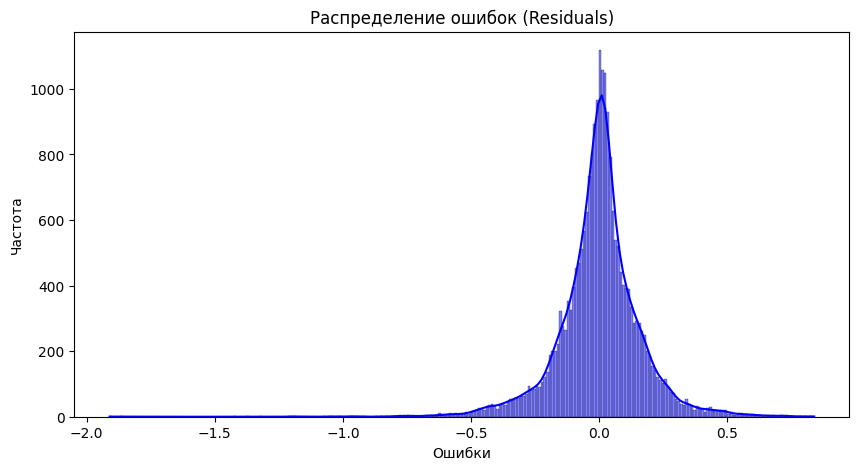

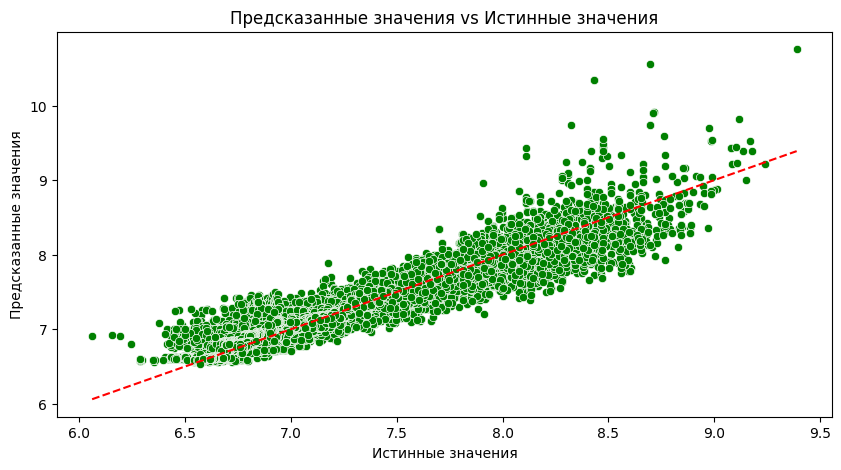

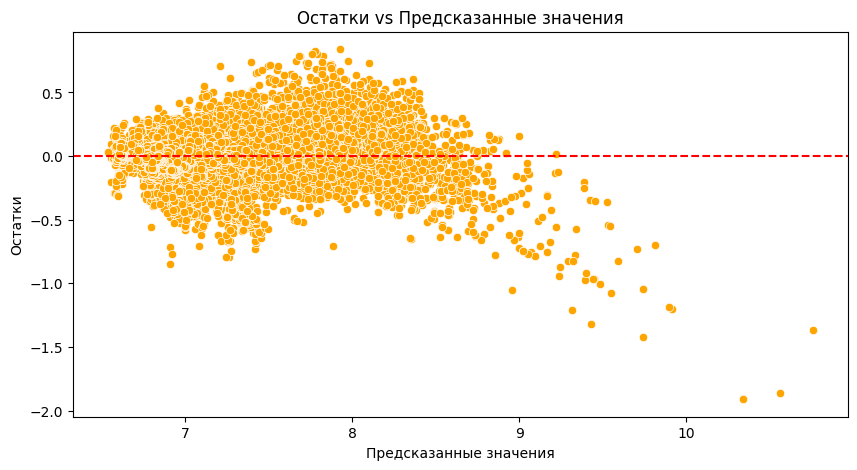


Проверка нормальности остатков:
W_statistic: 0.933 
 w_p_val: 0.0
Выборочное распределение не подчиняется нормальному закону по тесту Шапиро-Уилка.
W_statistic: 0.083 
 w_p_val: 0.0
Выборочное распределение не подчиняется нормальному закону по тесту Колмогорова-Смирнова.


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22676.
  res = hypotest_fun_out(*samples, **kwds)


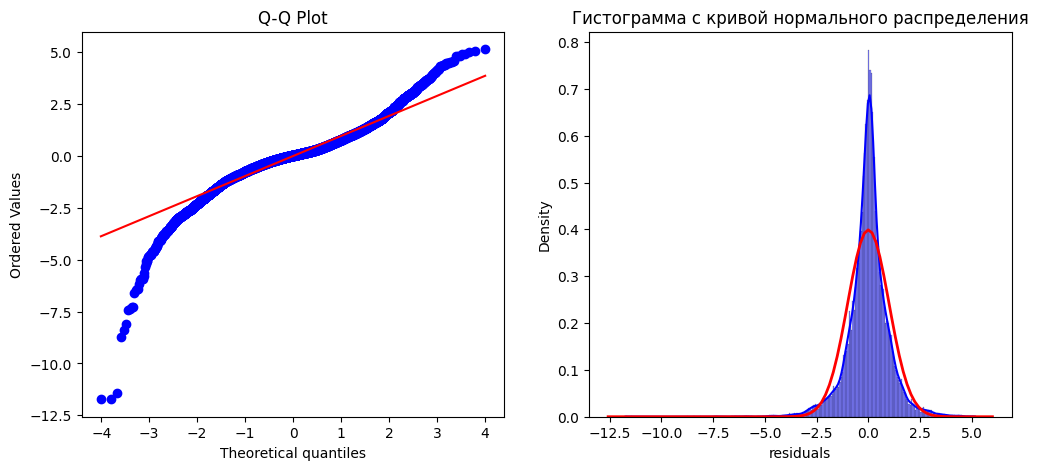

,lower,upper
const,7.00,7.02
Minutes to metro,-0.02,-0.02
Number of rooms,0.14,0.16
Area,0.10,0.12
Floor,0.01,0.02
Number of floors,0.01,0.02
district_Западный округ,0.14,0.18
district_Зеленоградский округ,-0.24,-0.15
district_Красногорск,0.11,0.14
district_Ленинский,0.07,0.10


In [ ]:
dataset, model, conf_intervals = train_model(
    dataset=final_df,
    target='Log_Price',
    feature_names=['Minutes to metro', 'Number of rooms', 'Area', 'Floor', 'Number of floors',
       'district_Западный округ', 'district_Зеленоградский округ',
       'district_Красногорск', 'district_Ленинский',
       'district_Новомосковский округ',
       'district_Подольск', 'district_Северный округ',
       'district_Северо-Восточный округ', 'district_Северо-Западный округ',
       'district_Центральный округ', 'district_Юго-Восточный округ',
       'district_Юго-Западный округ', 'district_Южный округ',
       'Renovation_Designer', 'Renovation_European-style renovation',
       'Renovation_Without renovation', 'Region_Moscow region',
       'Apartment type_Secondary'],
    show_results=True,
    return_norm_tests=True,
    robust=True
)

conf_intervals

#**Итоговые выводы**

**Особенности данных**

Распределение целевой переменной сильно отклоняется от нормального, с тяжелым правым хвостом и экстремальными выбросами. Логарифмирование целевой переменной (log-level преобразование) помогло стабилизировать описательные статистики и сделать распределение более интерпретируемым, хотя правый хвост всё ещё остается тяжелым.
Выбросы и большой разброс в ценах создают сложности для визуализации и анализа, несмотря на то, что логарифмирование сделало данные более подходящими для регрессионного анализа.

**Выбор спецификации**

Была выполнена нормализация признаков для равномерного влияния признаков на модель независимо от масштабов (например, шкалы площади квартиры и количества этажей отличаются в сотни раз). Мультиколлинеарность была устранена, что улучшило устойчивость оценок коэффициентов. Это особенно важно для таких признаков, как площадь квартиры, которая изначально демонстрировала сильную корреляцию с другими переменными.Финальная спецификация демонстрирует высокое качество: R² = 0.884, что означает, что 88.4% изменчивости логарифма цены объясняется включенными предикторами. Скорректированный R² (Adj. R² = 0.884) подтверждает, что модель хорошо специфицирована. Большинство переменных в финальной спецификации статистически значимы (p-значение < 0.05), за исключением 3х округов. В финальной модели использованы стандартные ошибки, устойчивые к гетероскедастичности, что повышает надежность оценок коэффициентов.

**Выявленные зависимости**

Коэффициенты модели интерпретируются в логарифмической шкале, что позволяет оценить их мультипликативное влияние на цену. Например:

- Количество комнат: Увеличение количества комнат на одну единицу приводит к увеличению цены на exp(0.1520) ≈ 1.164, то есть на 16.4%.

- Площадь: Увеличение площади на одну единицу увеличивает цену на exp(0.1102) ≈ 1.116, то есть на 11.6%.

- Время до метро: Увеличение времени до метро на одну минуту снижает цену на exp(-0.0192) ≈ 0.981, то есть на 1.9%.

- Этаж: Увеличение этажа на одну единицу увеличивает цену на exp(0.0148) ≈ 1.015, то есть на 1.5%.

- Количество этажей в доме: Увеличение количества этажей в доме на одну единицу увеличивает цену на exp(0.0139) ≈ 1.014, то есть на 1.4%.


**Нормальность остатков**

Остатки модели не подчиняются нормальному распределению, что подтверждается тестами Шапиро-Уилка и Колмогорова-Смирнова. Это может быть связано с большим объемом данных и наличием выбросов. Нарушение нормальности остатков указывает на возможные проблемы с спецификацией модели.

**Улучшения**

Логарифмирование целевой переменной улучшило интерпретируемость, но может приводить к корреляции ошибок с регрессорами и нарушению логики поведения целевой переменной. Для дальнейшего улучшения модели можно рассмотреть преобразования для учета возможных нелинейных зависимостей - например, логарифмирование не только целевой переменной, но и регрессоров. Можно рассмотреть сегментацию данных на группы (например, эконом, премиум, люкс) для более детального анализа. Это решение может повысить устойчивость модели, так как наибольший разброс и неустойчивость именно в группе дорогих квартир.Возможно использование других методов.

**Заключение**

Модель демонстрирует хорошее качество и устойчивость оценок коэффициентов после нормализации и устранения мультиколлинеарности. Однако нарушение нормальности остатков и наличие выбросов указывают на возможные проблемы с её спецификацией.